## Import data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


from custom_functions import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Import dataset that was cleaned and prepared in Data Preparation notebook

In [2]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM step2_encoded'''
df_main = pd.read_sql(query, conn, index_col='index').reset_index(drop=True)
conn.close()

y = 'SalePrice'
y_log = 'SalePrice_log'

# One-hot encode categoricals

#### Encode "HeatSystem"

In [3]:
# First, convert encoded values to text values so we can understand their meaning
keys = get_lookups(108)
print('Keys:', keys)
convert_to_keys = lambda x: keys[str(int(x))].replace(" ", "").replace('-','') if x!='0' else 'Other'
heating = df_main.HeatSystem.apply(convert_to_keys)
#print('Original breakdown:\n{}'.format(heating.value_counts()))

# We see that Gravity and Radiant are very uncommon. Let's lump them into the "Other" category
simplify = lambda x: 'Other' if x in ['Gravity', 'Radiant'] else x
heating = heating.apply(simplify)
#print('Improved categorization:\n{}'.format(heating.value_counts()))

# Now that we have appropriate categorization, let's one-hot encode
heating_dummies = pd.get_dummies(heating, prefix='Heating', drop_first=False).drop('Heating_ForcedAir', axis=1) # Choose to drop ForcedAir

#Adjust df_main accordingly
df_main.drop('HeatSystem', axis=1, inplace=True)
df_main = pd.concat([df_main, heating_dummies], axis=1)

Keys: {'1': 'Floor-Wall', '2': 'Gravity', '3': 'Radiant', '4': 'Elec BB', '5': 'Forced Air', '6': 'Hot Water', '7': 'Heat Pump', '8': 'Other'}


#### Encode "Condition"

In [4]:
keys = get_lookups(83)
print('Keys:', keys)
convert_to_keys = lambda x: keys[x].replace(' ', '')
condition = df_main.Condition.apply(convert_to_keys)
#print('\nBreakdown of conditions:\n{}'.format(condition.value_counts()))

condition_dummies = pd.get_dummies(condition, prefix='Condition', drop_first=False).drop('Condition_Average', axis=1)
df_main.drop('Condition', axis=1, inplace=True)
df_main = pd.concat([df_main, condition_dummies], axis=1)

Keys: {'1': 'Poor', '2': 'Fair', '3': 'Average', '4': 'Good', '5': 'Very Good'}


#### Encode "HeatSource"

In [5]:
keys = get_lookups(84)
apply_keys = lambda x: keys[x] if x!='0' else 'Other'
heat_source = df_main.HeatSource.apply(apply_keys)
#print('Original breakdown:\n{}'.format(heat_source.value_counts()))

# Now, combine the extremely small categories into an 'Other' bucket
simplify = lambda x: 'Other' if x in ['Gas/Solar', 'Electricity/Solar', 'Oil/Solar'] else x
heat_source = heat_source.apply(simplify)
#print('Improved categorization:\n{}'.format(heat_source.value_counts()))

heat_source_dummies = pd.get_dummies(heat_source, prefix='HeatSource', drop_first=False).drop('HeatSource_Gas', axis=1)

# Adjust df_main with results
df_main.drop('HeatSource', axis=1, inplace=True)
df_main = pd.concat([df_main, heat_source_dummies], axis=1)

#### Encode porch metrics

By default, the information given about porches is given in square feet. Instead of looking at the impact of porch size, we will investigate whether the presence of a deck impacts SalePrice

Encode as either enclosed, open, both, or neither. The default will be "neither", and as a result we will drop that column once encoded.

In [6]:
porches = df_main[['SqFtOpenPorch', 'SqFtEnclosedPorch']].copy()
porches.columns = ['Open', 'Encl']

classify_porches = lambda x: 'Both' if ((x.Open>0)&(x.Encl>0)) else 'Open' if x.Open>0 else 'Closed' if x.Encl>0 else 'None'

porches['Porch'] = porches.apply(classify_porches, axis=1)
porches_dummies = pd.get_dummies(porches['Porch'], prefix='Porch', drop_first=False).drop('Porch_None', axis=1)

df_main = pd.concat([df_main, porches_dummies], axis=1)
df_main.drop(['SqFtOpenPorch', 'SqFtEnclosedPorch'], axis=1, inplace=True)
porches['Porch'].value_counts();

#### Create one-hot column for whether a home has been renovated

In [7]:
#df_main.loc[df_main.YrRenovated>0, 'YrRenovated'].hist()
encode = lambda x: 1 if x>0 else 0
df_main['Renovated'] = df_main.YrRenovated.apply(encode)

#### Create one-hot column for whether there is a garage and deck

In [8]:
#plt.hist(df_main.SqFtGarageAttached)
encode = lambda x: 1 if x>0 else 0
df_main['Garage'] = df_main.SqFtGarageAttached.apply(encode)
#df_main.Garage.value_counts()

In [9]:
#plt.hist(df_main.SqFtDeck)
encode = lambda x: 1 if x>0 else 0
df_main['Deck'] = df_main.SqFtDeck.apply(encode)
#df_main.Deck.value_counts()

#### Indicate whether or not basement is finished

In [12]:
basement = df_main[['SqFtFinBasement', 'SqFtUnfinBasement']].copy()
basement.columns = ['fin', 'unfin']
classify_basements = lambda x: 'Unfinished' if ((x.fin>0)&(x.unfin>0)) else 'Finished' if x.fin>0 else 'Unfinished' if x.unfin>0 else 'None'
basement['Simplified'] = basement.apply(classify_basements, axis=1)
#print(basement.Simplified.value_counts())
basement_dummies = pd.get_dummies(basement.Simplified, prefix='Basement', drop_first=False).drop('Basement_None', axis=1)
df_main = pd.concat([df_main, basement_dummies], axis=1)

In [30]:
basement = df_main[['SqFtFinBasement', 'SqFtUnfinBasement']].copy()
basement.columns = ['fin', 'unfin']
classify_basements = lambda x: 'Unfinished' if ((x.fin>0)&(x.unfin>0)) else 'Finished' if x.fin>0 else 'Unfinished' if x.unfin>0 else 'None'
basement['Simplified'] = basement.apply(classify_basements, axis=1)
#print(basement.Simplified.value_counts())
basement_dummies = pd.get_dummies(basement.Simplified, prefix='Basement', drop_first=False).drop('Basement_Unfinished', axis=1)
df_main = pd.concat([df_main, basement_dummies], axis=1)

In [31]:
df_main

,SalePrice,NbrLivingUnits,Stories,BldgGrade,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageAttached,SqFtDeck,BrickStone,Bedrooms,YrBuilt,YrRenovated,SqFtUnfinBasement,SqFtUnfinished,Bathrooms,Fireplaces,Heating_ElecBB,Heating_FloorWall,Heating_HeatPump,Heating_HotWater,Heating_Other,Condition_Fair,Condition_Good,Condition_Poor,Condition_VeryGood,HeatSource_Electricity,HeatSource_Oil,HeatSource_Other,Porch_Both,Porch_Closed,Porch_Open,Renovated,Garage,Deck,Basement_Finished,Basement_Unfinished,SalePrice_log,SqFtTotLiving_log,Basement_Finished,Basement_None
0,445000,1,1.0,7,1480,0,0,0,440,120,0,3,1994,0,0,0,2.00,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,13.005830,7.299797,0,1
1,188500,1,1.0,5,550,0,0,0,0,0,0,2,1942,0,0,0,0.75,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,12.146853,6.309918,0,1
2,730000,1,2.0,9,1540,380,285,8,0,155,0,3,1984,0,95,0,2.25,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,13.500800,7.339538,0,0
3,1055700,1,1.0,8,2780,1390,1390,7,0,100,0,6,1967,0,0,0,1.75,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,13.869715,7.930206,1,0
4,565000,1,1.0,8,2230,1280,880,7,80,100,0,3,2015,0,400,0,2.00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,13.244581,7.709757,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18138,391000,1,1.0,8,1910,620,620,8,0,100,0,3,1985,0,0,0,2.25,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,12.876463,7.554859,1,0
18139,1535000,1,2.0,9,3220,0,0,0,630,0,0,4,2015,0,0,0,3.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,14.244041,8.077137,0,1
18140,309000,1,1.5,7,960,0,0,0,420,0,0,3,1959,0,0,0,1.00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,12.641097,6.866933,0,1
18141,759990,1,2.0,8,2010,0,0,0,440,0,0,4,1987,0,0,0,2.50,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,13.541061,7.605890,0,1


# Gain graphical understanding of data
Goal: find the best feature to start the model with. Start with continuous feature

In [13]:
# Identify continous features for pair-plot
continuous_features = []
for col in df_main.columns:
    ct = df_main[col].value_counts().shape[0]
    if (type(df_main[col][0])==type(np.int64(1))) or (type(df_main[col][0])==type(np.float64(0))):
        continuous_features.append(col) if ct>10 else False

sns.pairplot(df_main[continuous_features], kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'g'}, 'scatter_kws': {'alpha': 0.3}});

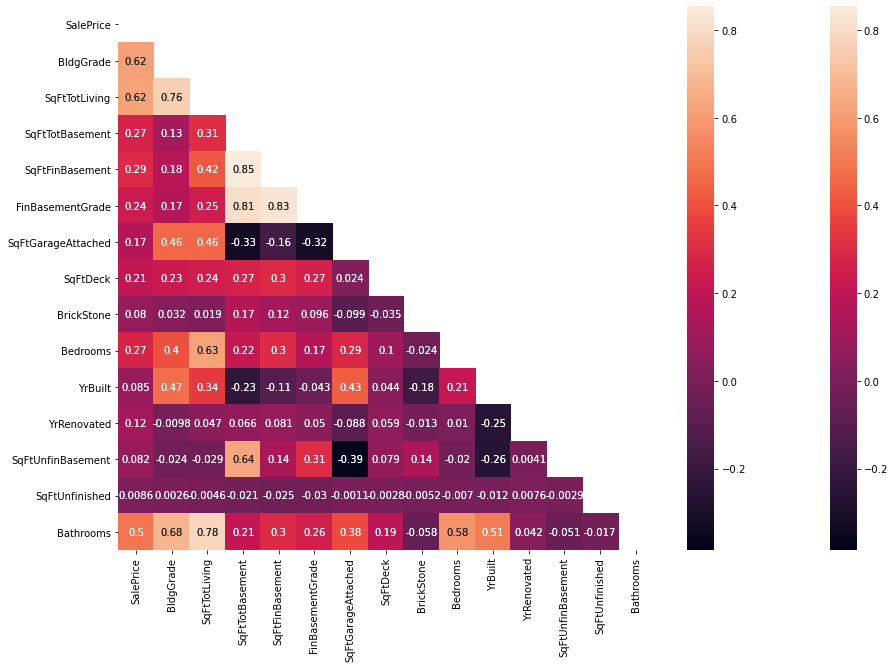

In [15]:
# Heatmap for continuous features
corr = df_main[continuous_features].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool)) # Formula taken from Flatiron School study group material
fig1, ax1 = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, mask=mask, ax=ax1, annot=True);
sns.heatmap(corr, mask=mask, annot=True);

# Create the single-variable model

#### Start with the feature showing the largest correlation with SalePrice

In [16]:
# List correlations of SalePrice and input features
correlations = df_main.corr().stack().reset_index()
correlations = correlations.loc[(correlations.level_0 == 'SalePrice') & (correlations.level_1 != 'SalePrice')]
correlations.columns = ['Dependent', 'Feature', 'Correlation (abs)']
correlations['Correlation (abs)'] = correlations['Correlation (abs)'].abs()
correlations.sort_values(by='Correlation (abs)', ascending=False, inplace=True, ignore_index=True)
correlations.head()

,Dependent,Feature,Correlation (abs)
0,SalePrice,SqFtTotLiving,0.622001
1,SalePrice,BldgGrade,0.615589
2,SalePrice,Bathrooms,0.496065
3,SalePrice,Fireplaces,0.322830
4,SalePrice,SqFtFinBasement,0.293849


#### Not surprisingly, the livable square footage is amongst the highest predictors

Let's create the simple model and check the assumptions of Linear Regression. Let's also create a dataframe to store the model performance metrics so we can compare them as we go.

In [17]:
performance_metrics_cols = ['Y', 'X', 'Linearity p-value', 'Jarque-Bera (JB) metric', 'JB p-value', 'Lagrange multiplier', 'Lagrange multiplier p-value', 'F-score', 'F-score p-value', 'Average VIF', 'R^2 (Adj.)']
performance_metrics = pd.DataFrame(columns = performance_metrics_cols)

Modeling: SalePrice ~ SqFtTotLiving 

Linearity p-value (where null hypothesis = linear): 2.3498371777527503e-05
Normality of Residuals (where null hypothesis = normality): JB stat=13052071.633737946, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=9.69930890498894e-96 and f-value's p-value=7.370337506432815e-97
Variance Inflation Factors: NA (single variable)


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852


<Figure size 432x288 with 0 Axes>

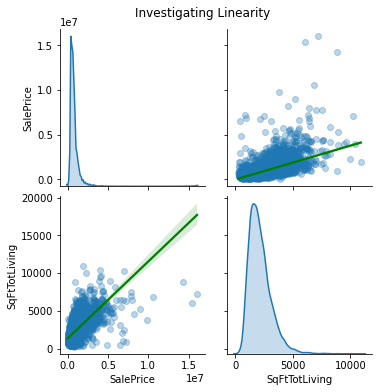

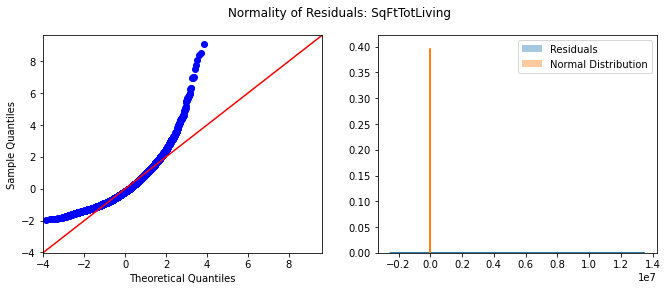

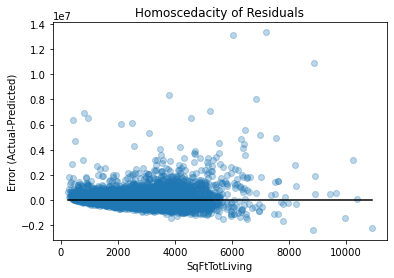

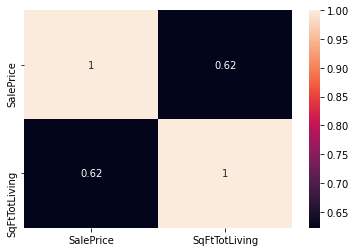

In [18]:
features = ['SqFtTotLiving']
model, df_model = produce_model(df_main, features, y=y)
results = check_assumptions(model, df_model, y, verbose=True, feature_to_plot=features[0])
performance_metrics = performance_metrics.append(results)
performance_metrics

##### Clearly, neither SalePrice or SqFtTotLiving are linear. Let's **log-transform** and see the effect

In [19]:
log_transform = lambda x: np.log(x)    
df_main['SalePrice_log'] = df_main.SalePrice.apply(log_transform)
df_main['SqFtTotLiving_log'] = df_main.SqFtTotLiving.apply(log_transform)

##### Model: **SqFtTotLiving_log**

Modeling: SalePrice_log ~ SqFtTotLiving_log 

Linearity p-value (where null hypothesis = linear): 0.3703812547440292
Normality of Residuals (where null hypothesis = normality): JB stat=5847.875160837674, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=0.0004431379335184857 and f-value's p-value=0.0004425453618993503
Variance Inflation Factors: NA (single variable)


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log,SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006


<Figure size 432x288 with 0 Axes>

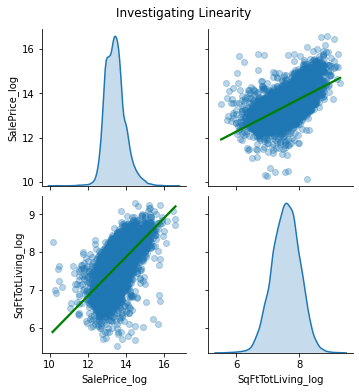

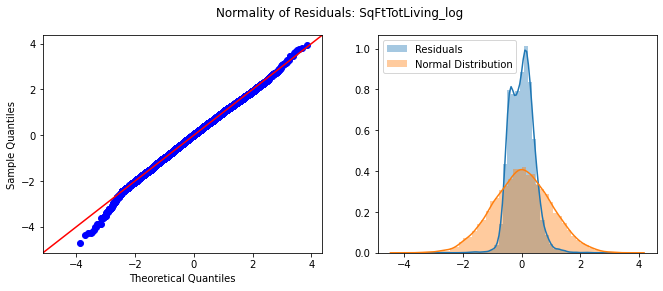

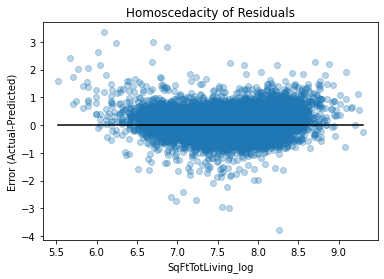

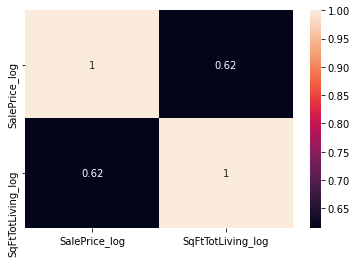

In [20]:
features = ['SqFtTotLiving_log']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=True, feature_to_plot=features[0])
performance_metrics = performance_metrics.append(results)
performance_metrics

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                 1.107e+04
Date:                Thu, 11 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:25:03   Log-Likelihood:                -9628.3
No. Observations:               18143   AIC:                         1.926e+04
Df Residuals:                   18141   BIC:                         1.928e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.8661      0.053    148.411      0.000       7.762       7.970
SqFtTotLiving_log     0.7348      0.007    105.230      0.000       0.721       0.748
==============================================================================
Omnibus:                     1325.115   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5847.875
Skew:                           0.225   Prob(JB):                         0.00
Kurtosis:                       5.745   Cond. No.                         134.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### This looks much better. Let's see which other features would be best to add using **RFE**

In [24]:
X = df_main.drop(['SalePrice_log'], axis=1)
y = df_main.SalePrice_log

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 10)
selector = selector.fit(X, y.values.ravel()) # convert y to 1d np array to prevent DataConversionWarning
top_features = X.loc[:, selector.support_].columns
top_features

Index(['BldgGrade', 'Heating_Other', 'Condition_Poor', 'Condition_VeryGood',
       'HeatSource_Other', 'Renovated', 'Garage', 'Basement_Finished',
       'Basement_Unfinished', 'SqFtTotLiving_log'],
      dtype='object')

##### BldgGrade is on the list, but we previously saw in the HeatMap that it has a very strong correlation with SqFtTotLiving. Let's not add it to the model so as to avoid colinearity. We do see both **Basement** one-hot metrics. Let's add those to the model and see the impact. 

In [26]:
features = ['SqFtTotLiving_log', 'Basement_Unfinished', 'Basement_Finished']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=True, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ SqFtTotLiving_log+Basement_Unfinished+Basement_Finished 

Linearity p-value (where null hypothesis = linear): 0.41339663901029255
Normality of Residuals (where null hypothesis = normality): JB stat=6971.160306811616, JB stat p-value=0.0
Homoscedacity (where null hypothesis = homoscedastic): lagrange p-value=8.326615434429143e-10 and f-value's p-value=8.134474819124228e-10

Variance Inflation Factors:
                Feature       VIF
0    SqFtTotLiving_log  1.942441
1  Basement_Unfinished  1.671342
2    Basement_Finished  1.271099


,Y,X,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice,SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log,SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log,SqFtTotLiving_log+Basement_Unfinished+Basement...,0.413397,6.971160e+03,0.0,45.215496,8.326615e-10,15.106156,8.134475e-10,1.62829,0.400528


In [27]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     4041.
Date:                Thu, 11 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:26:34   Log-Likelihood:                -9307.3
No. Observations:               18143   AIC:                         1.862e+04
Df Residuals:                   18139   BIC:                         1.865e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.9122      0.053    149.460      0.000       7.808       8.016
SqFtTotLiving_log       0.7190      0.007    102.664      0.000       0.705       0.733
Basement_Unfinished     0.1575      0.007     23.969      0.000       0.145       0.170
Basement_Finished       0.1445      0.009     15.318      0.000       0.126       0.163
==============================================================================
Omnibus:                     1394.528   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6971.160
Skew:                           0.190   Prob(JB):                         0.00
Kurtosis:                       6.013   Cond. No.                         136.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
features = ['SqFtTotLiving_log']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=True, feature_to_plot=features[0])
performance_metrics = performance_metrics.append(results)
performance_metrics

In [20]:
df_main.columns

Index(['SalePrice', 'Bathrooms', 'BldgGrade', 'YrBuilt', 'SqFtTotLiving',
       'Bedrooms', 'SqFtGarageAttached', 'YrRenovated', 'Heating_HotWater',
       'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other',
       'HeatSource_Other', 'Condition_VeryGood', 'HeatSource_Oil',
       'Heating_HeatPump', 'HeatSource_Electricity', 'Renovated',
       'SalePrice_log', 'SqFtTotLiving_log'],
      dtype='object')

In [13]:
cols_to_include = ['SalePrice_log', 'Condition', 'SqFtTotLiving_log', 'NbrLivingUnits', 'Stories', 'BldgGrade', 'SqFtTotLiving',
       'SqFtTotBasement', 'SqFtFinBasement', 'SqFtGarageAttached', 'SqFtDeck', 'BrickStone', 'Bedrooms', 'YrBuilt',
       'YrRenovated', 'SqFtUnfinBasement', 'SqFtUnfinished', 'Bathrooms',
       #'Fireplaces', 'Heating_ElecBB', 'Heating_FloorWall', 'Heating_HeatPump',
       'Heating_HotWater', 'Heating_Other', 'Condition_Fair', 'Condition_Good',
       'Condition_Poor', 'Condition_VeryGood']#, 'HeatSource_Electricity',
       #'HeatSource_Oil', 'HeatSource_Other', 'Porch_Both', 'Porch_Closed',
       #'Porch_Open', 'Renovated', 'Garage', 'Deck', 'basement_Finished',
       #'basement_Unfinished']
#model_new = forward_selected(df_main[cols_to_include], 'SalePrice_log')
#model_new.summary()



print(list(model_new.params.index))



remaining_features = ['Condition', 'BldgGrade', 'YrBuilt', 'SqFtTotLiving', 'SqFtGarageAttached', 'Stories', 'Bathrooms', 'Bedrooms', 'SqFtDeck', 'Heating_Other', 'SqFtTotBasement', 
                    'YrRenovated', 'BrickStone', 'SqFtTotLiving_log', 'SqFtFinBasement', 'Heating_HotWater', 'SqFtUnfinBasement']

#remaining_features = ['BldgGrade','YrBuilt','SqFtTotLiving','SqFtGarageAttached','Stories','Bathrooms','Bedrooms','SqFtDeck','basement_Finished','basement_Unfinished','Heating_Other',
#                    'SqFtFinBasement','Heating_HeatPump','HeatSource_Electricity','Condition_VeryGood','YrRenovated','SqFtTotLiving_log','BrickStone','Porch_Open','HeatSource_Other',
#                      'Condition_Poor','Renovated', 'HeatSource_Oil','Garage','Condition_Fair','Condition_Good','Heating_HotWater','Heating_FloorWall','NbrLivingUnits','Fireplaces']

for col in remaining_features:
    cols_to_include.remove(col) if col in cols_to_include else True

cols_to_include

In [22]:
col_names = ['Formula', 'Linearity p-value', 'Jarque-Bera (JB) metric', 'JB p-value', 'Lagrange multiplier', 'Lagrange multiplier p-value', 'F-score', 'F-score p-value', 'Average VIF', 'R^2 (Adj.)']
performance_metrics = pd.DataFrame(columns = col_names)

In [13]:


X = df_main[remaining_features].drop(['BldgGrade', 'Stories', 'Bathrooms'], axis=1)
y = df_main.SalePrice_log

# linreg = LinearRegression()
# selector = RFE(linreg, n_features_to_select = 5)
# selector = selector.fit(X, y.values.ravel()) # convert y to 1d np array to prevent DataConversionWarning
# X_RFE = X.loc[:, selector.support_]

# keepers = stepwise_selection(X_RFE, df_main[y_log], verbose=False)

# # Determine which features were removed
# removed = list(df_main.drop(y_log, axis=1).columns)
# for item in keepers:
#     removed.remove(item)

# print('\nRemaining features:', keepers)
# print('\nRemoved features:', removed)

#TEMP
keepers = remaining_features

df_input = df_main[[y_log]+keepers]
model, df_model = produce_model(df_input, keepers, y=y_log)
model.summary()
#results=check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=False)

#performance_metrics = performance_metrics.append(results)
#performance_metrics
model.summary()

Modeling: SalePrice_log ~ SqFtTotLiving_log+BldgGrade+Garage+Renovated+Condition_VeryGood+HeatSource_Oil+basement_Finished+basement_Unfinished+Bedrooms+Bathrooms+Condition_Good+Porch_Open+Heating_Other+HeatSource_Other+Heating_HotWater+NbrLivingUnits+HeatSource_Electricity+Heating_FloorWall+Heating_HeatPump+Condition_Poor 



,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice_log~SqFtTotLiving_log+BldgGrade+Gara...,0.112085,11897.712058,0.0,137.19631,1.718974e-19,6.904084,1.425236e-19,26.38301,0.564052


In [52]:
selector.support_

array([ True, False, False, False, False,  True,  True, False,  True,
        True,  True, False,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False])

In [20]:
model_this = pd.concat([df_main.SqFtTotLiving_log, df_main.SalePrice_log, df_main.iloc[:, 1:10]], axis=1)
model_this.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18143 entries, 0 to 18142
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SqFtTotLiving_log   18143 non-null  float64
 1   SalePrice_log       18143 non-null  float64
 2   NbrLivingUnits      18143 non-null  int64  
 3   Stories             18143 non-null  float64
 4   BldgGrade           18143 non-null  int64  
 5   SqFtTotLiving       18143 non-null  int64  
 6   SqFtTotBasement     18143 non-null  int64  
 7   SqFtFinBasement     18143 non-null  int64  
 8   FinBasementGrade    18143 non-null  int64  
 9   SqFtGarageAttached  18143 non-null  int64  
 10  SqFtDeck            18143 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1.5 MB


In [21]:
model_new = forward_selected(model_this, 'SalePrice_log')
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     2255.
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:50:00   Log-Likelihood:                -6620.4
No. Observations:               18143   AIC:                         1.326e+04
Df Residuals:                   18132   BIC:                         1.335e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.5247      0.132     94.886      0.000      12.266      12.783
BldgGrade              0.2186      0.004     57.159      0.000       0.211       0.226
SqFtTotBasement        0.0001   9.85e-06     10.493      0.000     8.4e-05       0.000
SqFtTotLiving          0.0003   9.51e-06     26.655      0.000       0.000       0.000
SqFtGarageAttached    -0.0003   1.27e-05    -25.665      0.000      -0.000      -0.000
SqFtTotLiving_log     -0.1855      0.020     -9.475      0.000      -0.224      -0.147
SqFtDeck            8.835e-05   1.29e-05      6.829      0.000     6.3e-05       0.000
Stories                0.0339      0.006      5.264      0.000       0.021       0.047
SqFtFinBasement     -3.68e-05   1.44e-05     -2.560      0.010    -6.5e-05   -8.62e-06
NbrLivingUnits         0.0811      0.025      3.221      0.001       0.032       0.130
FinBasementGrade      -0.0031      0.002     -2.030      0.042      -0.006      -0.000
==============================================================================
Omnibus:                     1628.678   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11036.025
Skew:                          -0.103   Prob(JB):                         0.00
Kurtosis:                       6.815   Cond. No.                     1.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Implement new forward-selection feature

In [ ]:
new_model = forward_selected(simplified, y_log)
new_model.summary()

# Step-wise feature selection: remove features with low p-value

In [11]:
# Run Step-wise selection algorithm to eliminate irrelevant features
X = df_main.drop(y, axis=1)
keepers = stepwise_selection(X, df_main[y], verbose=True)

# Determine which features were removed
removed = list(df_main.drop(y, axis=1).columns)
for item in keepers:
    removed.remove(item)

print('\nRemaining features:', keepers)
print('\nRemoved features:', removed)


df_removed = df_main[removed].copy()

df_main = df_main[[y] + keepers].copy()

Add  SqFtFinBasement                with p-value 0.0
Add  Bathrooms                      with p-value 0.0
Add  BldgGrade                      with p-value 0.0
Add  YrBuilt                        with p-value 0.0
Add  SqFtTotLiving                  with p-value 5.69727e-135
Add  Bedrooms                       with p-value 1.31849e-120
Add  SqFtGarageAttached             with p-value 1.49713e-81
Drop SqFtFinBasement                with p-value 0.482165
Add  YrRenovated                    with p-value 2.17328e-09
Add  Heating_HotWater               with p-value 3.53294e-08
Add  Heating_FloorWall              with p-value 1.88038e-06
Add  Heating_ElecBB                 with p-value 1.30417e-06
Add  Heating_Other                  with p-value 5.0394e-07
Add  HeatSource_Other               with p-value 4.60187e-05
Add  Condition_VeryGood             with p-value 0.000209514
Add  HeatSource_Oil                 with p-value 0.000583019
Add  Heating_HeatPump               with p-value 0.0005074

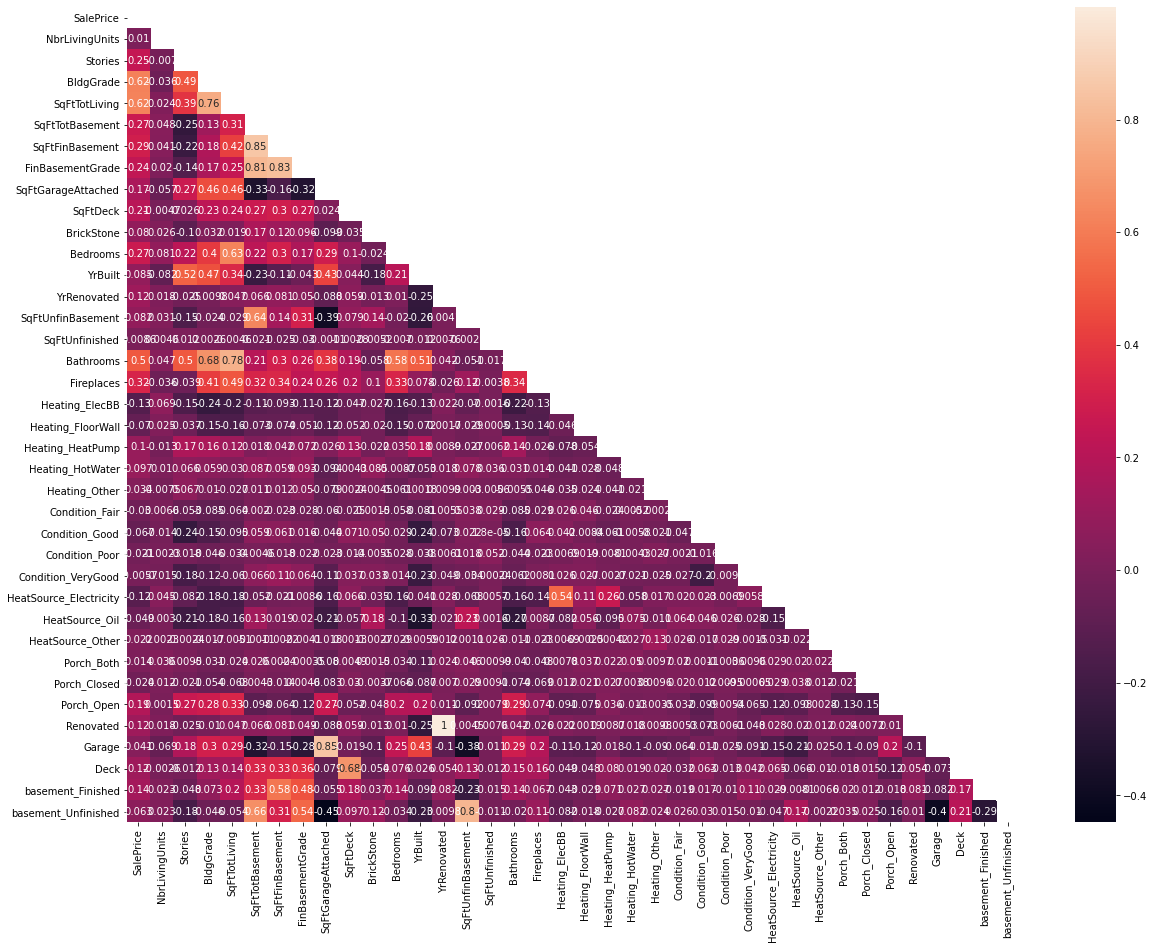

In [14]:
corr = df_main.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool)) # Formula taken from Flatiron School study group material
fig1, ax1 = plt.subplots(figsize=(20, 15))
sns.heatmap(corr, mask=mask, ax=ax1, annot=True);

In [21]:
features = ['SqFtTotLiving_log', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=[])
performance_metrics = performance_metrics.append(results)

Modeling: SalePrice_log ~ SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other 



In [22]:
performance_metrics

,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706


### Add 'Renovated?' to the model

In [23]:
features = ['SqFtTotLiving_log', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other', 'Renovated']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=[])
performance_metrics = performance_metrics.append(results)

Modeling: SalePrice_log ~ SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other+Renovated 



In [24]:
performance_metrics

,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.435412,5.554476e+03,0.0,37.644525,1.318183e-06,6.284707,1.301266e-06,1.06437,0.399442


As we see above, "Renovated" didn't add any substantial value to the model. Let's exclude it for now

### Add SqFtGarageAttached to the model

In [25]:
features = ['SqFtTotLiving_log', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other', 'SqFtGarageAttached']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=['SqFtGarageAttached'])
performance_metrics = performance_metrics.append(results)

Modeling: SalePrice_log ~ SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other+SqFtGarageAttached 



In [26]:
performance_metrics

,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.435412,5.554476e+03,0.0,37.644525,1.318183e-06,6.284707,1.301266e-06,1.06437,0.399442
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.517671,6.498752e+03,0.0,24.385944,4.434074e-04,4.068224,4.415889e-04,1.42045,0.401147


#### We see from the historgram/distplot that SqFtGarageAttached is far from Linear. Let's log transform it then try again.
Note that this does exclude a lot of data since there are lots of homes with no garages, hence 0 sqft, that need to be converted to np.nan since log(0) = -inf

In [27]:
garage_log = df_main.SqFtGarageAttached.map(lambda x: np.nan if x==0 else np.log(x))
df_main['SqFtGarageAttached_log'] = garage_log


features = ['SqFtTotLiving_log', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other', 'SqFtGarageAttached_log']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other+SqFtGarageAttached_log 



,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.435412,5.554476e+03,0.0,37.644525,1.318183e-06,6.284707,1.301266e-06,1.06437,0.399442
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.517671,6.498752e+03,0.0,24.385944,4.434074e-04,4.068224,4.415889e-04,1.42045,0.401147
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.605413,2.539372e+03,0.0,82.717501,9.799887e-16,13.893519,8.461405e-16,61.8258,0.492699


Phew. That was a terrible addition. Let's keep the non-log transformed version instead.

#### Let's add 'Bedrooms' data

In [28]:
features = ['Bedrooms', 'SqFtTotLiving_log', 'SqFtGarageAttached', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=['Bedrooms'])
performance_metrics = performance_metrics.append(results)

Modeling: SalePrice_log ~ Bedrooms+SqFtTotLiving_log+SqFtGarageAttached+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other 



In [29]:
# Added Bedrooms
performance_metrics

,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.435412,5.554476e+03,0.0,37.644525,1.318183e-06,6.284707,1.301266e-06,1.06437,0.399442
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.517671,6.498752e+03,0.0,24.385944,4.434074e-04,4.068224,4.415889e-04,1.42045,0.401147
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.605413,2.539372e+03,0.0,82.717501,9.799887e-16,13.893519,8.461405e-16,61.8258,0.492699
0,SalePrice_log~Bedrooms+SqFtTotLiving_log+SqFtG...,0.638829,6.457007e+03,0.0,67.561841,4.587626e-12,9.683496,4.368225e-12,6.99613,0.413285


In [30]:
# Removed SqFtLivingArea
# Result: it destroys all metrics. Leave it in.

features = ['Bedrooms', 'SqFtGarageAttached', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=['Bedrooms'])
performance_metrics = performance_metrics.append(results)

Modeling: SalePrice_log ~ Bedrooms+SqFtGarageAttached+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other 



In [31]:
performance_metrics

,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.435412,5.554476e+03,0.0,37.644525,1.318183e-06,6.284707,1.301266e-06,1.06437,0.399442
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.517671,6.498752e+03,0.0,24.385944,4.434074e-04,4.068224,4.415889e-04,1.42045,0.401147
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.605413,2.539372e+03,0.0,82.717501,9.799887e-16,13.893519,8.461405e-16,61.8258,0.492699
0,SalePrice_log~Bedrooms+SqFtTotLiving_log+SqFtG...,0.638829,6.457007e+03,0.0,67.561841,4.587626e-12,9.683496,4.368225e-12,6.99613,0.413285
0,SalePrice_log~Bedrooms+SqFtGarageAttached+Heat...,0.152911,2.877179e+03,0.0,136.010678,6.957978e-27,22.830854,5.525574e-27,1.41243,0.147747


In [32]:
# Removed 

features = ['SqFtTotLiving', 'SqFtGarageAttached', 'Heating_HotWater', 'Heating_FloorWall', 'Heating_ElecBB', 'Heating_Other']
model, df_model = produce_model(df_main, features, y=y_log)
results = check_assumptions(model, df_model, y_log, verbose=False, feature_to_plot=False)
performance_metrics = performance_metrics.append(results)
performance_metrics

Modeling: SalePrice_log ~ SqFtTotLiving+SqFtGarageAttached+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other 



,Formula,Linearity p-value,Jarque-Bera (JB) metric,JB p-value,Lagrange multiplier,Lagrange multiplier p-value,F-score,F-score p-value,Average VIF,R^2 (Adj.)
0,SalePrice~SqFtTotLiving,0.000023,1.305207e+07,0.0,431.029855,9.699309e-96,441.470516,7.370338e-97,NA,0.386852
0,SalePrice_log~SqFtTotLiving_log,0.370381,5.847875e+03,0.0,12.340914,4.431379e-04,12.347953,4.425454e-04,NA,0.379006
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.523410,5.623625e+03,0.0,16.134461,6.470484e-03,3.228696,6.461908e-03,1.05676,0.391706
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.435412,5.554476e+03,0.0,37.644525,1.318183e-06,6.284707,1.301266e-06,1.06437,0.399442
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.517671,6.498752e+03,0.0,24.385944,4.434074e-04,4.068224,4.415889e-04,1.42045,0.401147
0,SalePrice_log~SqFtTotLiving_log+Heating_HotWat...,0.605413,2.539372e+03,0.0,82.717501,9.799887e-16,13.893519,8.461405e-16,61.8258,0.492699
0,SalePrice_log~Bedrooms+SqFtTotLiving_log+SqFtG...,0.638829,6.457007e+03,0.0,67.561841,4.587626e-12,9.683496,4.368225e-12,6.99613,0.413285
0,SalePrice_log~Bedrooms+SqFtGarageAttached+Heat...,0.152911,2.877179e+03,0.0,136.010678,6.957978e-27,22.830854,5.525574e-27,1.41243,0.147747
0,SalePrice_log~SqFtTotLiving+SqFtGarageAttached...,0.555153,6.199852e+03,0.0,176.758632,1.655195e-35,29.738130,1.109816e-35,1.50844,0.454811


In [33]:
for x in performance_metrics.Formula:
    print(x)

SalePrice~SqFtTotLiving
SalePrice_log~SqFtTotLiving_log
SalePrice_log~SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other
SalePrice_log~SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other+Renovated
SalePrice_log~SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other+SqFtGarageAttached
SalePrice_log~SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other+SqFtGarageAttached_log
SalePrice_log~Bedrooms+SqFtTotLiving_log+SqFtGarageAttached+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other
SalePrice_log~Bedrooms+SqFtGarageAttached+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other
SalePrice_log~SqFtTotLiving+SqFtGarageAttached+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other


In [34]:
SalePrice_log~SqFtTotLiving_log+Heating_HotWater+Heating_FloorWall+Heating_ElecBB+Heating_Other

SyntaxError: invalid syntax (<ipython-input-34-f5fd74307970>, line 1)

In [4]:
10**0.1767

1.5021039909500773

In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     2523.
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:02:56   Log-Likelihood:                -8444.8
No. Observations:               18143   AIC:                         1.690e+04
Df Residuals:                   18136   BIC:                         1.696e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             12.6858      0.008   1688.303      0.000      12.671      12.701
SqFtTotLiving          0.0004   3.42e-06    111.868      0.000       0.000       0.000
SqFtGarageAttached    -0.0003   1.12e-05    -23.754      0.000      -0.000      -0.000
Heating_HotWater       0.1767      0.019      9.478      0.000       0.140       0.213
Heating_FloorWall     -0.0163      0.017     -0.968      0.333      -0.049       0.017
Heating_ElecBB        -0.1328      0.012    -10.891      0.000      -0.157      -0.109
Heating_Other          0.2046      0.022      9.417      0.000       0.162       0.247
==============================================================================
Omnibus:                     1241.410   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6199.852
Skew:                          -0.076   Prob(JB):                         0.00
Kurtosis:                       5.860   Cond. No.                     1.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     2085.
Date:                Tue, 09 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:03:06   Log-Likelihood:            -1.3738e+05
No. Observations:                9814   AIC:                         2.748e+05
Df Residuals:                    9795   BIC:                         2.749e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -2.436e+06    4.1e+05     -5.937      0.000   -3.24e+06   -1.63e+06
SalePrice_log           9.107e+05   9050.048    100.633      0.000    8.93e+05    9.28e+05
SqFtTotLiving            492.5363     11.432     43.084      0.000     470.127     514.946
SqFtTotLiving_log      -1.171e+06   2.75e+04    -42.659      0.000   -1.23e+06   -1.12e+06
SqFtGarageAttached_log  1.205e+05   1.55e+04      7.759      0.000    9.01e+04    1.51e+05
SqFtGarageAttached      -388.9482     38.174    -10.189      0.000    -463.776    -314.120
Bathrooms               7.555e+04   7486.710     10.091      0.000    6.09e+04    9.02e+04
Renovated               5.077e+06   2.44e+06      2.080      0.038    2.91e+05    9.86e+06
Bedrooms               -2.693e+04   4802.640     -5.608      0.000   -3.63e+04   -1.75e+04
Heating_HotWater        1.377e+05   3.02e+04      4.563      0.000    7.86e+04    1.97e+05
BldgGrade               2.432e+04   4757.109      5.112      0.000     1.5e+04    3.36e+04
YrBuilt                 -995.9053    190.778     -5.220      0.000   -1369.869    -621.941
Heating_Other          -9.477e+04    3.6e+04     -2.636      0.008   -1.65e+05   -2.43e+04
Heating_FloorWall      -5.883e+04   2.73e+04     -2.151      0.031   -1.12e+05   -5222.758
Heating_HeatPump       -1.926e+04   1.13e+04     -1.697      0.090   -4.15e+04    2981.727
YrRenovated            -2473.4113   1219.027     -2.029      0.042   -4862.956     -83.866
HeatSource_Other       -1.083e+05   5.44e+04     -1.993      0.046   -2.15e+05   -1761.885
HeatSource_Oil          -2.91e+04   1.63e+04     -1.786      0.074    -6.1e+04    2843.090
HeatSource_Electricity -1.073e+04   9597.125     -1.118      0.264   -2.95e+04    8085.598
==============================================================================
Omnibus:                    19646.515   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        108106541.110
Skew:                          16.023   Prob(JB):                         0.00
Kurtosis:                     516.173   Cond. No.                     2.71e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""